In [1]:
options(warn=-1)
library(tidyverse)
library(emdbook)
library(gridExtra)
library(latex2exp)
library(FITSio)
library(gplots)

── Attaching core tidyverse packages ──────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Caricamento pacchetto: 'gridExtra'


Il seguente oggetto è mascherato da 'package:dplyr':

    combine




ERROR: Error in library(FITSio): non c'è alcun pacchetto chiamato 'FITSio'


# The algorithm

## Validate Input

In [17]:
validate.input = function(data, data_type='Events'){
    
    cells = data
    
    #using the data.frame structure
    if (!is.data.frame(cells)){
        
        cells = as.data.frame(cells)
    }
    
    if (data_type=='Events'){
        #count the number of times an event is registered
        cells = cells |> count(cells)
        #sort along times
        return(cells[order(cells[1]), "columns"])
    }
    
    if (data_type=='RegularEvents'){
       # In each tick, there are either zero or one counts. 
        #just sorting along times
        return(cells[order(cells[1]), ])
    }
    
    if (data_type=='PointMeasures'){
        #just sorting along times
        
        #return(cells[order(cells[1]), "columns"])
        return(arrange(cells, cells[1]))
    }
    
}

## Compute Prior

In [3]:
compute.p0_prior = function(N, p0=0.05){
    return(4 - log(73.53 * p0 * (N**-0.478))) 
}

In [4]:
compute.ncp_prior = function(gamma=NULL, N){
    if (is.null(gamma)){
        return(compute.p0_prior(N))
    }
    else{
        return(-log(gamma))
    }
}

## Compute Fitness

In [5]:
compute.fitness = function(count_vec, width, dt=NULL, a_k=NULL, b_k=NULL, data_type='Events'){
    
    if (data_type=='Events'){
        return(count_vec*log(count_vec/width))
    }
    else if (data_type=='RegularEvents'){
        M = width/dt
        count_vec_over_M = count_vec/M
        
        esp = 1e-8
        if (sum(count_vec_over_M > 1+esp) > 0){
            cat("regular events: N/M > 1.  Is the time step correct?")
            break
        }
        
        one_m_NM = 1 - count_vec_over_M
        count_vec_over_M[count_vec_over_M <= 0] = 1
        one_m_NM[one_m_NM <= 0] = 1
        
        return(count_vec * log(count_vec_over_M) + (M  - count_vec)*log(one_m_NM))
    }
    else if(data_type=='PointMeasures'){
        return( (b_k*b_k)/(4*a_k) )
    }
    
}

## Bayesian Blocks

In [6]:
bayesian_blocks = function(data, ncp_prior=NULL, gamma=NULL, dt=NULL, data_type='Events'){
    
    cells = validate.input(data, data_type)
    
    t = cells[[1]]
    x = cells[[2]]
    if (length(data)==3){sigma = cells[[3]]} #length(data) returns the number of columns of the dataframe 
    else{sigma = 1}
    N = length(t)
    

   
    #quantities needed for the computation of a_k, b_k
    ak_raw = rep(x = 1, times=length(x))/sigma**2
    bk_raw = x/sigma**2
    ck_raw = (x*x)/sigma**2
    
    edges = c(t[1],  0.5 * (t[2:length(t)] + t[1:(length(t)-1)] ), t[length(t)])
    block_length = t[length(t)] - edges
    
    best = rep(0, times = N)
    last = rep(1, times = N)
    
    #-----------------------------------------------------------------
    # Start with first data cell; add one cell at each iteration
    #-----------------------------------------------------------------
    
    for (K in seq(1:N)){
        # Compute the width and count of the final bin for all possible
        # locations of the K^th changepoint
        width = block_length[1:K] - block_length[K + 1] #T_K
        count_vec = rev(cumsum(rev(x[1:K]))) #N_K
        
        a_k = NULL
        b_k = NULL
        
        if (is.null(ncp_prior)){
            ncp_prior = compute.ncp_prior(gamma, N)
        }
        
        if (data_type !='Events' ){
            a_k = 0.5*rev(cumsum(rev(ak_raw[1:K])))
            b_k = -1 * rev(cumsum(rev(bk_raw[1:K])))
        }
        
        
        fit_vec = compute.fitness(count_vec = count_vec, width = width, a_k=a_k, b_k=b_k, dt=dt, data_type)
        
        post_vec = fit_vec - ncp_prior
        
        post_vec[2:length(post_vec)] = post_vec[2:length(post_vec)] + best[1:(K-1)]
        
        i_max = which.max(post_vec)
        last[K] = i_max
        best[K] = post_vec[i_max]
    }
    
    #-----------------------------------------------------------------
    # Recover changepoints by iteratively peeling off the last block
    #-----------------------------------------------------------------

    change_points =  rep(1, times=N)
    i_cp = N
    ind = N+1
    
    while (i_cp>1){
        change_points[i_cp] = ind
        if (ind == 1){ break }
        i_cp = i_cp-1
        ind = last[ind - 1]
    }
    
    if (i_cp==1){change_points[i_cp] = 1}
    change_points = change_points[i_cp:length(change_points)]

    return(edges[change_points])
}

# Algorithm performances
Let us define some toy data in order to evaluate the performancies of the algorithm implementation as the number of points increases.

In [ ]:
#This cell was used to make the benchmark, it takes a lot of time to run. The results are stored in the 'Benchmark_N2.csv' file.
n.list = seq(100, 10000, length.out = 10)
n.attempts = 10

time.list.avg = c()
time.list.std = c()

for (n in n.list){
    time.attempts = c()
    for (i in seq(1, n.attempts)){
        
        t.events.unif = runif(n, min=0, max=100)

        start_time = Sys.time()

        edges = bayesian_blocks(data=t.events.unif, data_type = 'Events')

        end_time = Sys.time()
        exec_time = as.numeric(end_time - start_time)

        time.attempts = c(time.attempts, exec_time)
    }
    
    time.list.avg = c(time.list.avg, mean(time.attempts))
    time.list.std = c(time.list.std, sd(time.attempts))

}

df = data.frame(n = n.list, time = time.list.avg, lower = time.list.avg-time.list.std, upper = time.list.avg+time.list.std)
write.csv(df, 'Benchmark_N2.csv',row.names=FALSE)

In [7]:
df = read.csv('./data/Benchmark_N2.csv')

x = df$n
y = df$time
dy = df$time - df$lower

In [8]:
fit <- nls(y ~ A*x^2, start = list(A = 0.00000004), weights = dy^-2)

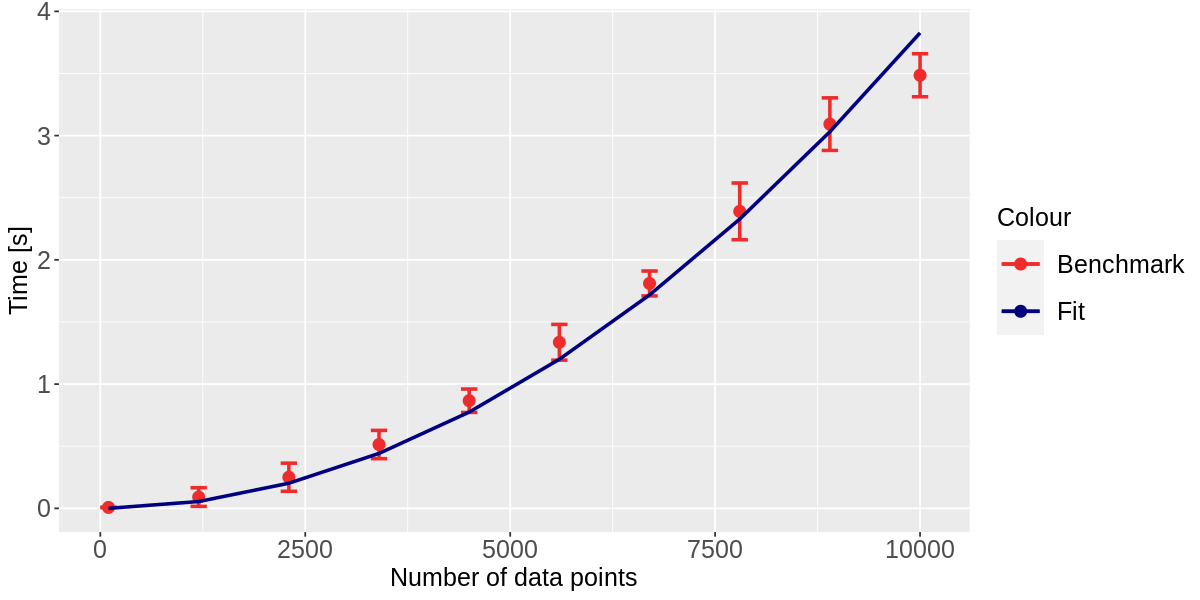

In [9]:
linspace=seq(1,10000, length.out = 10000)
# fit = 0.00000004*linspace^2

options(repr.plot.width = 10, repr.plot.height =5)
p.N2 = ggplot(df, aes(n, time))+
geom_point(aes(color=as.factor(1)), size=3)+
geom_errorbar(aes(ymin=lower,
                  ymax=upper,color=as.factor(1)), width = 200, size=1)+

geom_line(data=data.frame(x=x, fit = predict(fit)), aes(x=x, fit, color=as.factor(2)), linewidth=1)+

theme(axis.text.x=element_text(size=15),
      axis.text.y=element_text(size=15),
      axis.title.x = element_text(size=15),
      axis.title.y = element_text(size=15),
      legend.text= element_text(size=15),
      legend.title= element_text(size=15),
      legend.key.size = unit(1, 'cm'))+

scale_colour_manual(name = "Colour",
                    labels = c('Benchmark', 'Fit'),
                    values = c('firebrick2', 'navy'))+

labs(x='Number of data points', y = 'Time [s]')

p.N2

# Toy Data

## [Events] Unifrom and Normal model

In [10]:
t.uniform = runif(1000, min=0, max=100)
x.uniform = rep(1, 1000)

edges.uniform = bayesian_blocks(t.uniform)

N.uniform = length(t.uniform)
N.edges.uniform = length(edges.uniform)


steps.uniform = rep(0, length(N.edges.uniform))

    for (K in seq(1: N.edges.uniform)){
        
        steps.uniform[K] = sum(x.uniform[t.uniform>=edges.uniform[K] & t.uniform<edges.uniform[K+1]])/sum(x.uniform*(edges.uniform[K+1] -edges.uniform[K]))
        
        if (K==N.edges.uniform-1){break}
    }
steps.uniform[N.edges.uniform] = steps.uniform[N.edges.uniform-1]

#data hist and bayesian blocks
p.unif = ggplot()+
geom_histogram(aes(t.uniform, y=after_stat(density), color=as.factor(1), fill=as.factor(1)), alpha=0.5, bins=31)+
geom_step(aes(edges.uniform, steps.uniform, color=as.factor(2), fill=as.factor(2)), linewidth=1)+
# geom_density(aes(t.uniform, color=as.factor(3), fill = as.factor(3)), alpha=0, linewidth=1)+

scale_colour_manual(name = "Binning",
                    labels = c(TeX(r'($\sqrt{N}$)'), 'BB'),
                    values = c('firebrick2', 'navy'))+

scale_fill_manual(name = "Binning",
                  labels=c(TeX(r'($\sqrt{N}$)'), 'BB'),
                  values=c('firebrick2', 'navy'))+

theme(axis.text.x=element_text(size=15),
      axis.text.y=element_text(size=15),
      axis.title.x = element_text(size=15),
      axis.title.y = element_text(size=15),
      legend.text= element_text(size=15),
      legend.title= element_text(size=15),
      legend.position = 'none',
      legend.key.size = unit(0.5, 'cm'))+


labs(x = 'Samples', y='Density')+
xlim(-0.5,100.5)


#plot pdf
x.unif= seq(0,100, length.out = 10000)
p.unif_pdf = ggplot() + geom_line(aes(x=x.unif, y=dunif(x=x.unif, min = 0, max = 100), color='PDF')) +

scale_colour_manual(name = 'color',
                    labels = 'PDF',
                    values = c('firebrick2'))+

theme(axis.text.x=element_text(size=15),
      axis.text.y=element_text(size=15),
      axis.title.x = element_text(size=15),
      axis.title.y = element_text(size=15),
      legend.text= element_text(size=15),
      legend.title= element_text(size=15),
      legend.position = 'none',
      legend.key.size = unit(0.5, 'cm'))+

labs(x = 'Samples', y='Density')+
xlim(-0.5, 100.5)+
ylim(0, 0.015)


In [11]:
t.normal = rnorm(mean = 0, sd =0.5, n = 1000 )
x.normal = rep(1, 1000)


edges.normal = bayesian_blocks(t.normal)
N.normal = length(t.normal)
N.edges.normal = length(edges.normal)


steps.normal = rep(0, length(N.edges.normal))

    for (K in seq(1: N.edges.normal)){
        
        steps.normal[K] = sum(x.normal[t.normal>=edges.normal[K] & t.normal<edges.normal[K+1]])/sum(x.normal*(edges.normal[K+1] -edges.normal[K]))
        
        if (K==N.edges.normal-1){break}
    }
steps.normal[N.edges.normal] = steps.normal[N.edges.normal-1]


p.norm = ggplot()+
               
geom_histogram(aes(t.normal, y=after_stat(density), color=as.factor(1), fill=as.factor(1)), alpha=0.5, bins=31)+
geom_step(aes(edges.normal, steps.normal, color=as.factor(2), fill=as.factor(2)), linewidth=1)+

scale_colour_manual(name = "Binning",
                    labels = c(TeX(r'($\sqrt{N}$)'),'BB'),
                    values = c('firebrick2', "navy"))+

scale_fill_manual(name = "Binning",
                    labels = c(TeX(r'($\sqrt{N}$)'),'BB'),
                    values = c('firebrick2', "navy"))+

theme(axis.text.x=element_text(size=15),
      axis.text.y=element_text(size=15),
      axis.title.x = element_text(size=15),
      axis.title.y = element_text(size=15),
      legend.text= element_text(size=15),
      legend.title= element_text(size=15),
      legend.key.size = unit(0.5, 'cm'))+

labs(x = 'Samples', y='Density')+
xlim(-3.5, 3.5)

#plot pdf
x.lin = seq(-3,3, length.out = 10000)
p.norm_pdf = ggplot() + geom_line(aes(x=x.lin, y=dnorm(x=x.lin,mean = 0, sd =0.5), color='PDF')) +

scale_colour_manual(name = 'color',
                    labels = 'PDF',
                    values = c('firebrick2'))+

theme(axis.text.x=element_text(size=15),
      axis.text.y=element_text(size=15),
      axis.title.x = element_text(size=15),
      axis.title.y = element_text(size=15),
      legend.text= element_text(size=15),
      legend.title= element_text(size=15),
      legend.key.size = unit(0.5, 'cm'))+

labs(x = 'Samples', y='Density')+
xlim(-3.5, 3.5)

TableGrob (2 x 2) "arrange": 4 grobs
  z     cells    name           grob
1 1 (1-1,1-1) arrange gtable[layout]
2 2 (1-1,2-2) arrange gtable[layout]
3 3 (2-2,1-1) arrange gtable[layout]
4 4 (2-2,2-2) arrange gtable[layout]

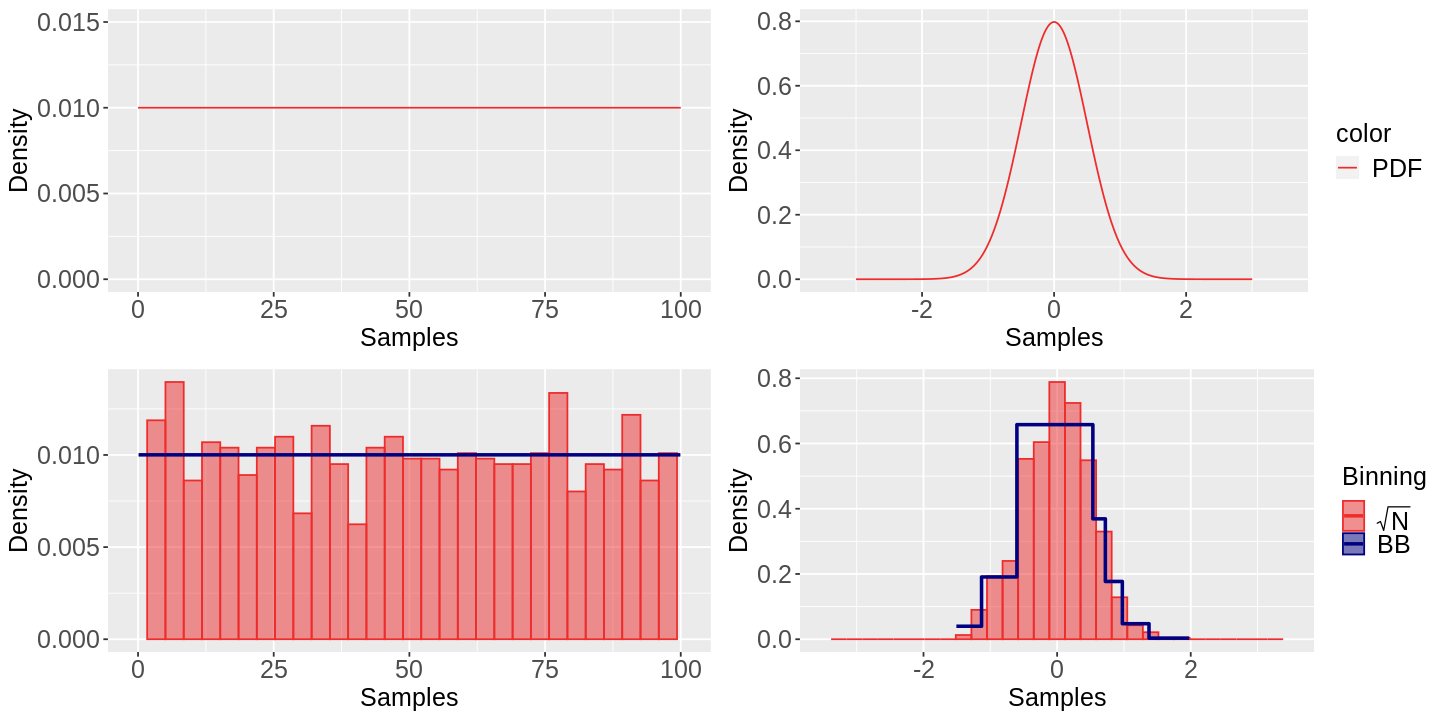

In [12]:
options(repr.plot.width = 12, repr.plot.height =6)
p.toy_final = grid.arrange(grobs=list(p.unif_pdf, p.norm_pdf, p.unif, p.norm), nrow=2, ncol=2)

p.toy_final


# KDE Vs BB

In [13]:
test = c(runif(1000, min=0, max=100),rnorm(100, mean =10, sd = 4 ), rnorm(100, mean =40, sd = 1 ))
counts = rep(1, 1200)
x.lin = seq(0,100, length.out = 10000)

density = dunif(x.lin, min=0, max=100) + dnorm(x.lin,mean =10, sd = 4 ) + dnorm(x.lin,mean = 40, sd = 1 )
density = density/sum(density*0.01)

edges = bayesian_blocks(test)
N.edges = length(edges)

steps = rep(0, length(N.edges))

    for (K in seq(1: N.edges)){
        
        steps[K] = sum(counts[test>=edges[K] & test<edges[K+1]])/sum(counts*(edges[K+1] -edges[K]))
        
        if (K==N.edges-1){break}
    }
steps[N.edges] = steps[N.edges-1]

TableGrob (2 x 1) "arrange": 2 grobs
  z     cells    name           grob
1 1 (1-1,1-1) arrange gtable[layout]
2 2 (2-2,1-1) arrange gtable[layout]

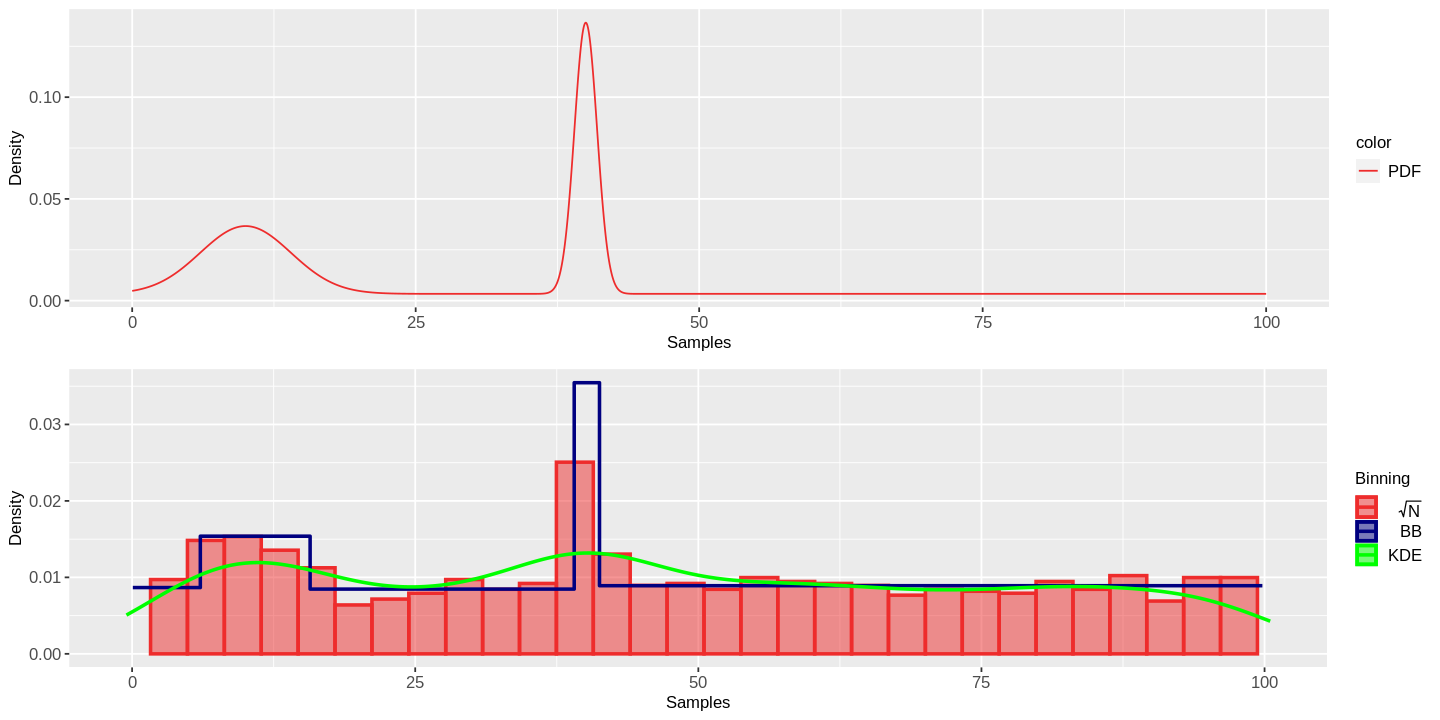

In [14]:
#plot pdf
p.pdf_kde = ggplot()+geom_line(aes(x = x.lin, y=density, color='probability density function')) +

scale_colour_manual(name = 'color',
                    labels = 'PDF',
                    values = c('firebrick2'))+

theme(axis.text.x=element_text(size=10),
      axis.text.y=element_text(size=10),
      axis.title.x = element_text(size=10),
      axis.title.y = element_text(size=10),
      legend.text= element_text(size=10),
      legend.title= element_text(size=10),
      legend.key.size = unit(0.5, 'cm'))+

xlim(-0.5, 100.5)+

labs(x='Samples', y='Density') 

#plot kde + bayesian blocks
p.kde = ggplot()+
geom_histogram(aes(test, y=after_stat(density), color=as.factor(1), fill=as.factor(1)), bins=32, alpha=0.5, linewidth=1)+

geom_step(aes(edges, steps, , color=as.factor(2), fill=as.factor(2)), linewidth=1)+

geom_density(aes(test,, color=as.factor(3), fill=as.factor(3)), linewidth=1, alpha=0)+

scale_colour_manual(name = "Binning",
                    labels = c(TeX(r'($\sqrt{N}$)'),'BB', 'KDE'),
                    values = c('firebrick2', "navy", 'green'))+

scale_fill_manual(name = "Binning",
                    labels = c(TeX(r'($\sqrt{N}$)'),'BB', 'KDE'),
                    values = c('firebrick2', "navy", 'green'))+

theme(axis.text.x=element_text(size=10),
      axis.text.y=element_text(size=10),
      axis.title.x = element_text(size=10),
      axis.title.y = element_text(size=10),
      legend.text= element_text(size=10),
      legend.title= element_text(size=10),
      legend.key.size = unit(0.5, 'cm'))+

xlim(-0.5, 100.5)+

labs(x='Samples', y='Density')

#arrangeGrob and save
p.kde_total = grid.arrange(grobs=list(p.pdf_kde, p.kde), nrow=2)

p.kde_total


## [Point Measures] Prior dependency
This code was used to create the images used in the .gif file that display the prior dependency of the algorithm. This code takes a lot of time to run.

# Applications

## BATSE TTE (event 0551)

In [15]:
plot_tte_events = function(path){
    
    data = read_delim(path, delim=',')
    a = str_extract(string = path, pattern = '\\d+.csv' )
    channel_number = gsub('.csv', '', a)
    channel_number = as.numeric(channel_number)

    steps = rep(0, length(edges))
    for (K in seq(1:length(edges))){
        steps[K] = mean(data$x[data$t>=edges[K] & data$t<=edges[K+1]])
        if (K==(length(edges)-1)){break}
    }
    steps[length(edges)] = steps[length(edges)-1]


    energy_channel = as.numeric(data[[1]])
    x = rep(1, length.out = length(energy_channel))
    edges = bayesian_blocks(energy_channel)

    N = length(energy_channel)
    N.edges = length(edges)


    steps = rep(0, length(N.edges))
        for (K in seq(1: N.edges)){

            steps[K] = sum(x[energy_channel>=edges[K] & energy_channel<edges[K+1]])/sum(x*(edges[K+1] - edges[K]))

            if (K==N.edges-1){break}
        }
    steps[N.edges] = steps[N.edges-1]


    plot_energy_channel = ggplot()+
    geom_histogram(aes(x=energy_channel, y = after_stat(density), color=as.factor(1), fill=as.factor(1)), alpha=0.5) +
    geom_step(aes(x = edges, y = steps, color=as.factor(2), fill=as.factor(2)), linewidth=1)+

    scale_colour_manual(name = "Binning",
                        labels = c(TeX(r'($\sqrt{N}$)'), 'BB'),
                        values = c('firebrick2', 'navy'))+

    scale_fill_manual(name = "Binning",
                      labels=c(TeX(r'($\sqrt{N}$)'), 'BB'),
                      values=c('firebrick2', 'navy'))+


    labs(x='Times [s]', y = 'Counts', title=sprintf('Channel %s', channel_number)) +
    
    if (channel_number%%2==0){
    theme(axis.text.x=element_text(size=15),
          axis.text.y=element_text(size=15),
          axis.title.x = element_text(size=15),
          axis.title.y = element_text(size=15),
          legend.text= element_text(size=15),
          legend.title= element_text(size=15),
          legend.key.size = unit(0.5, 'cm'))
    }
    else{
    theme(axis.text.x=element_text(size=15),
          axis.text.y=element_text(size=15),
          axis.title.x = element_text(size=15),
          axis.title.y = element_text(size=15),
          legend.text= element_text(size=15),
          legend.title= element_text(size=15),
          legend.position = 'none',
          legend.key.size = unit(0.5, 'cm'))
    }

    
    return(plot_energy_channel)
}

Rows: 4742 Columns: 1
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (1): Energy_channel_1

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 689 Columns: 1
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (1): Energy_channel_2

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 6043 Columns: 1
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (1): Energy_channel_3

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 4218 Columns: 1
── Column specification ────────────────────────────────────────────────────────
D

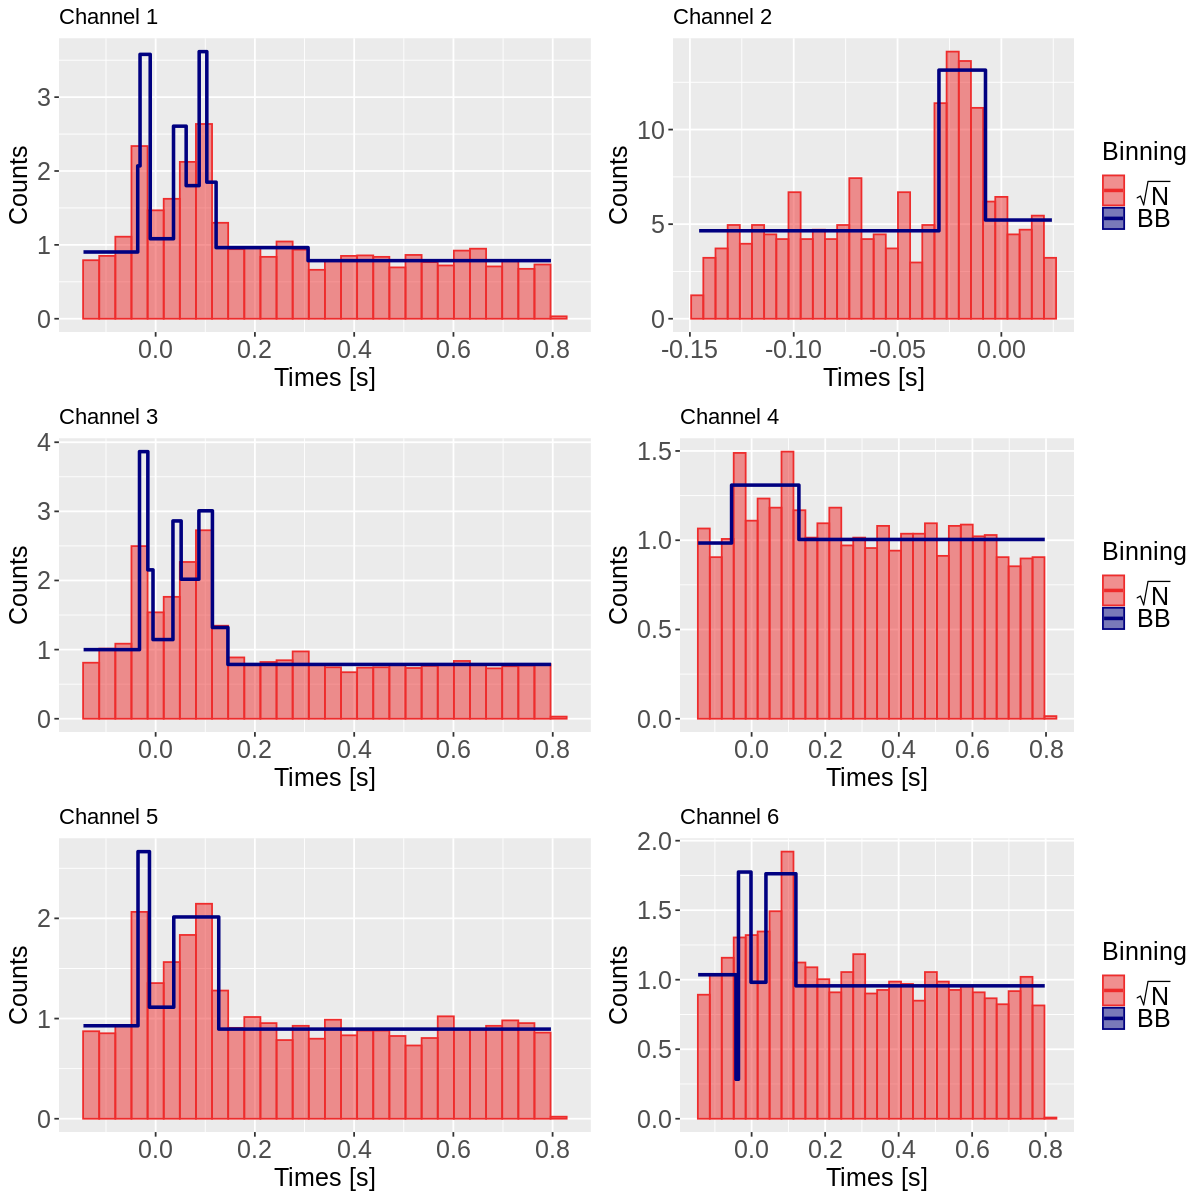

In [16]:
list_of_plots = c('data/Energy_channel_1.csv', 'data/Energy_channel_2.csv', 'data/Energy_channel_3.csv', 'data/Energy_channel_4.csv', 'data/Energy_channel_5.csv', 'data/Energy_channel_6.csv')
plots = lapply(list_of_plots, plot_tte_events)
options(repr.plot.width = 10, repr.plot.height = 10)
tte_551_plot = do.call(grid.arrange, c(grobs=plots, nrow=3))


## $\gamma$-ray light curves radio quasar sources

### Event 3C273

In [18]:
data = read.csv('../data/light_curve_3C273_weekly.csv')

edges = bayesian_blocks(data = data, data_type = 'PointMeasures')
cat('number of edges:', length(edges))

number of edges: 81

In [18]:
#counting mean over edges
steps = rep(0, length(edges))
for (K in seq(1:length(edges))){
    steps[K] = mean(data$x[data$t>=edges[K] & data$t<=edges[K+1]])
    if (K==(length(edges)-1)){break}
}
steps[length(edges)] = steps[length(edges)-1]


p.lc1.bb = ggplot()+
geom_step(aes(x=edges, y = steps, colour=as.factor(1)))+
geom_point(aes(x=data$t, y=data$x, color=as.factor(2)), size=0.5, alpha=0.5)+
geom_errorbar(aes(x = data$t, y = data$x, ymin=(data$x -data$sigma), ymax=(data$x + data$sigma), color=as.factor(2)), linewidth=0.5, alpha=0.5)+

scale_colour_manual(name = "Colour",
                    labels = c('Bayesian Blocks', 'Measurements'),
                    values = c('navy', 'firebrick2'))+

theme(axis.text.x=element_text(size=15),
      axis.text.y=element_text(size=15),
      axis.title.x = element_text(size=15),
      axis.title.y = element_text(size=15),
      legend.text= element_text(size=15),
      legend.title= element_text(size=15),
      legend.key.size = unit(1, 'cm'))+

labs(x='Time [MJD-54000]', y=TeX('Flux $[cm^{-2} s^{-1}]$'))


p.lc1.mes = ggplot()+
geom_point(aes(x=data$t, y=data$x, color=as.factor(1)), size=0.8, alpha=1)+
geom_errorbar(aes(x = data$t, y = data$x, ymin=(data$x -data$sigma), ymax=(data$x + data$sigma), color=as.factor(1)), linewidth=0.5, alpha=1,width = 30)+
scale_colour_manual(name = "Colour",
                    labels = c('Measurements'),
                    values = c('firebrick2'))+
theme(axis.text.x=element_text(size=15),
      axis.text.y=element_text(size=15),
      axis.title.x = element_text(size=15),
      axis.title.y = element_text(size=15),
      legend.text= element_text(size=15),
      legend.title= element_text(size=15),
      legend.key.size = unit(1, 'cm'))+

labs(x='Time [MJD-54000]', y=TeX('Flux $[cm^{-2} s^{-1}]$'))

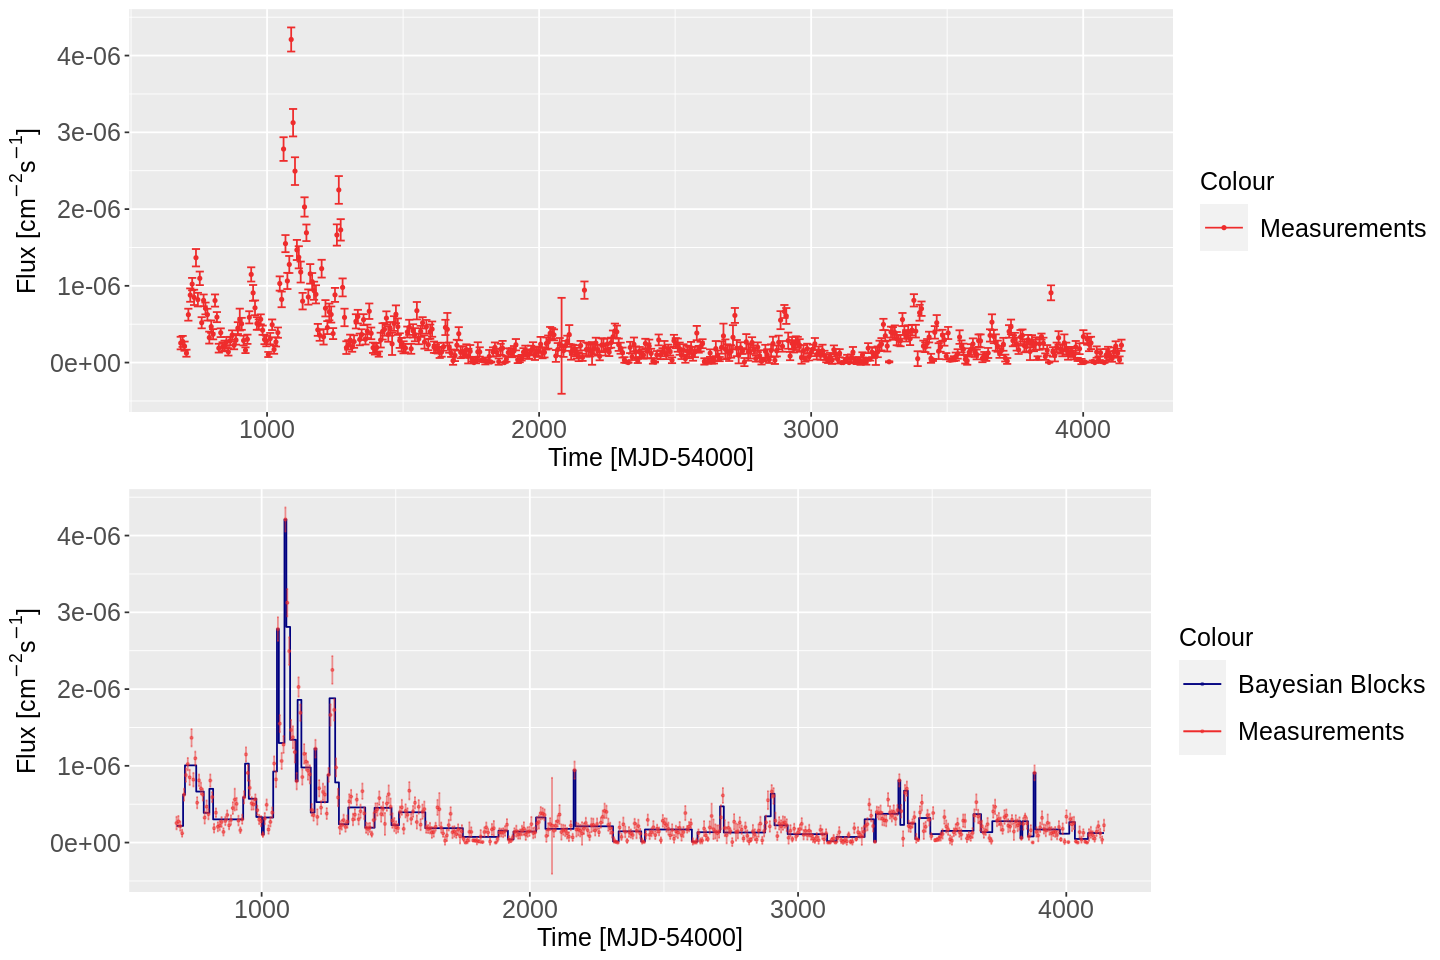

In [19]:
options(repr.plot.width = 12, repr.plot.height =8)
p.lc1 = grid.arrange(grobs=list(p.lc1.mes, p.lc1.bb), nrow=2)

### Event PKS1510

In [20]:
data = read_csv('data/light_curve_PKS1510_weekly.csv')

edges = bayesian_blocks(data = data, data_type = 'PointMeasures')
cat('number of edges:', length(edges))

Rows: 494 Columns: 3
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (3): t, x, sigma

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


number of edges: 122

In [21]:
#counting mean over edges
steps = rep(0, length(edges))
for (K in seq(1:length(edges))){
    steps[K] = mean(data$x[data$t>=edges[K] & data$t<=edges[K+1]])
    if (K==(length(edges)-1)){break}
}
steps[length(edges)] = steps[length(edges)-1]


p.lc2.bb = ggplot()+
geom_step(aes(x=edges, y = steps, colour=as.factor(1)))+
geom_point(aes(x=data$t, y=data$x, color=as.factor(2)), size=0.5, alpha=0.5)+
geom_errorbar(aes(x = data$t, y = data$x, ymin=(data$x -data$sigma), ymax=(data$x + data$sigma), color=as.factor(2)), linewidth=0.5, alpha=0.5)+

scale_colour_manual(name = "Colour",
                    labels = c('Bayesian Blocks', 'Measurements'),
                    values = c('navy', 'firebrick2'))+

theme(axis.text.x=element_text(size=15),
      axis.text.y=element_text(size=15),
      axis.title.x = element_text(size=15),
      axis.title.y = element_text(size=15),
      legend.text= element_text(size=15),
      legend.title= element_text(size=15),
      legend.key.size = unit(1, 'cm'))+

labs(x='Time [MJD-54000]', y=TeX('Flux $[cm^{-2} s^{-1}]$'))

p.lc2.mes = ggplot()+
geom_point(aes(x=data$t, y=data$x, color=as.factor(1)), size=0.8, alpha=1)+
geom_errorbar(aes(x = data$t, y = data$x, ymin=(data$x -data$sigma), ymax=(data$x + data$sigma), color=as.factor(1)), linewidth=0.5, alpha=1,width = 30)+
scale_colour_manual(name = "Colour",
                    labels = c('Measurements'),
                    values = c('firebrick2'))+
theme(axis.text.x=element_text(size=15),
      axis.text.y=element_text(size=15),
      axis.title.x = element_text(size=15),
      axis.title.y = element_text(size=15),
      legend.text= element_text(size=15),
      legend.title= element_text(size=15),
      legend.key.size = unit(1, 'cm'))+

labs(x='Time [MJD-54000]', y=TeX('Flux $[cm^{-2} s^{-1}]$'))


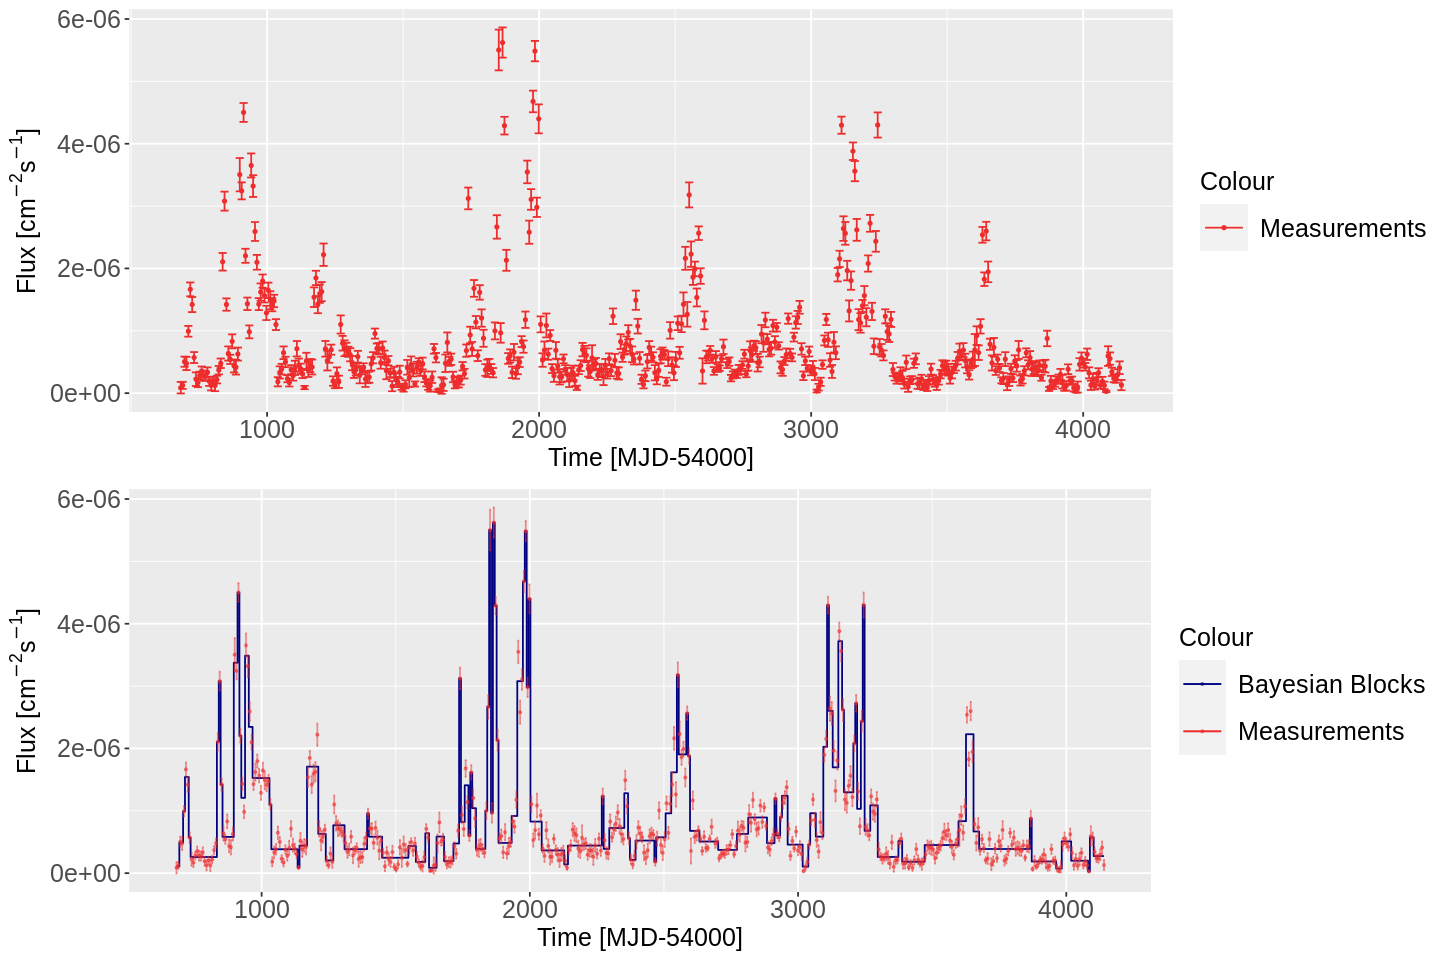

In [22]:
options(repr.plot.width = 12, repr.plot.height =8)
p.lc2 = grid.arrange(grobs=list(p.lc2.mes, p.lc2.bb), nrow=2)

## Heartrate ECG

In [23]:
ecg_data = read_csv2(file = 'data/ecg.csv')

ecg_data = ecg_data[1:1000,]

ℹ Using "','" as decimal and "'.'" as grouping mark. Use `read_delim()` for more control.

Rows: 150001 Columns: 2
── Column specification ────────────────────────────────────────────────────────
Delimiter: ";"
dbl (2): ms, heartrate

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [24]:
p.ecg.mes = ggplot()+
geom_line(aes(x = ecg_data$ms, y = ecg_data$heartrate, color=as.factor(1)), size=0.1, linewidth=0.7)+

scale_colour_manual(name = "Colour",
                    labels = c('ECG'),
                    values = c('firebrick2'))+

theme(axis.text.x=element_text(size=15),
      axis.text.y=element_text(size=15),
      axis.title.x = element_text(size=15),
      axis.title.y = element_text(size=15),
      legend.text= element_text(size=15),
      legend.title= element_text(size=15),
      legend.key.size = unit(1, 'cm'))+
xlim(0, 1200)+
labs(x=TeX('Time $[ms]$'), y = TeX('ECG $[mu V]$'))


edges = bayesian_blocks(data = ecg_data, data_type = 'PointMeasures', ncp=100)

#counting mean over edges
steps = rep(0, length(edges))
for (K in seq(1:length(edges))){
    steps[K] = mean(ecg_data$heartrate[ ecg_data$ms>=edges[K] & ecg_data$ms<=edges[K+1] ])
    if (K==(length(edges)-1)){break}
}
steps[length(edges)] = steps[length(edges)-1]

p.ecg.bb = ggplot()+
geom_line(aes(x = ecg_data$ms, y=ecg_data$heartrate, color=as.factor(2)), linewidth=0.7, alpha=1)+
geom_step(aes(x=edges, y = steps, colour=as.factor(1)), linewidth=1)+

scale_colour_manual(name = "Colour",
                    labels = c('BB', 'ECG'),
                    values = c('navy', 'firebrick2'))+

theme(axis.text.x=element_text(size=15),
      axis.text.y=element_text(size=15),
      axis.title.x = element_text(size=15),
      axis.title.y = element_text(size=15),
      legend.text= element_text(size=15),
      legend.title= element_text(size=15),
      legend.key.size = unit(1, 'cm'))+
# xlim(0, 600) +
xlim(0, 1200)+
labs(x='Time [ms]', y=TeX('ECG $[mu V]$'));


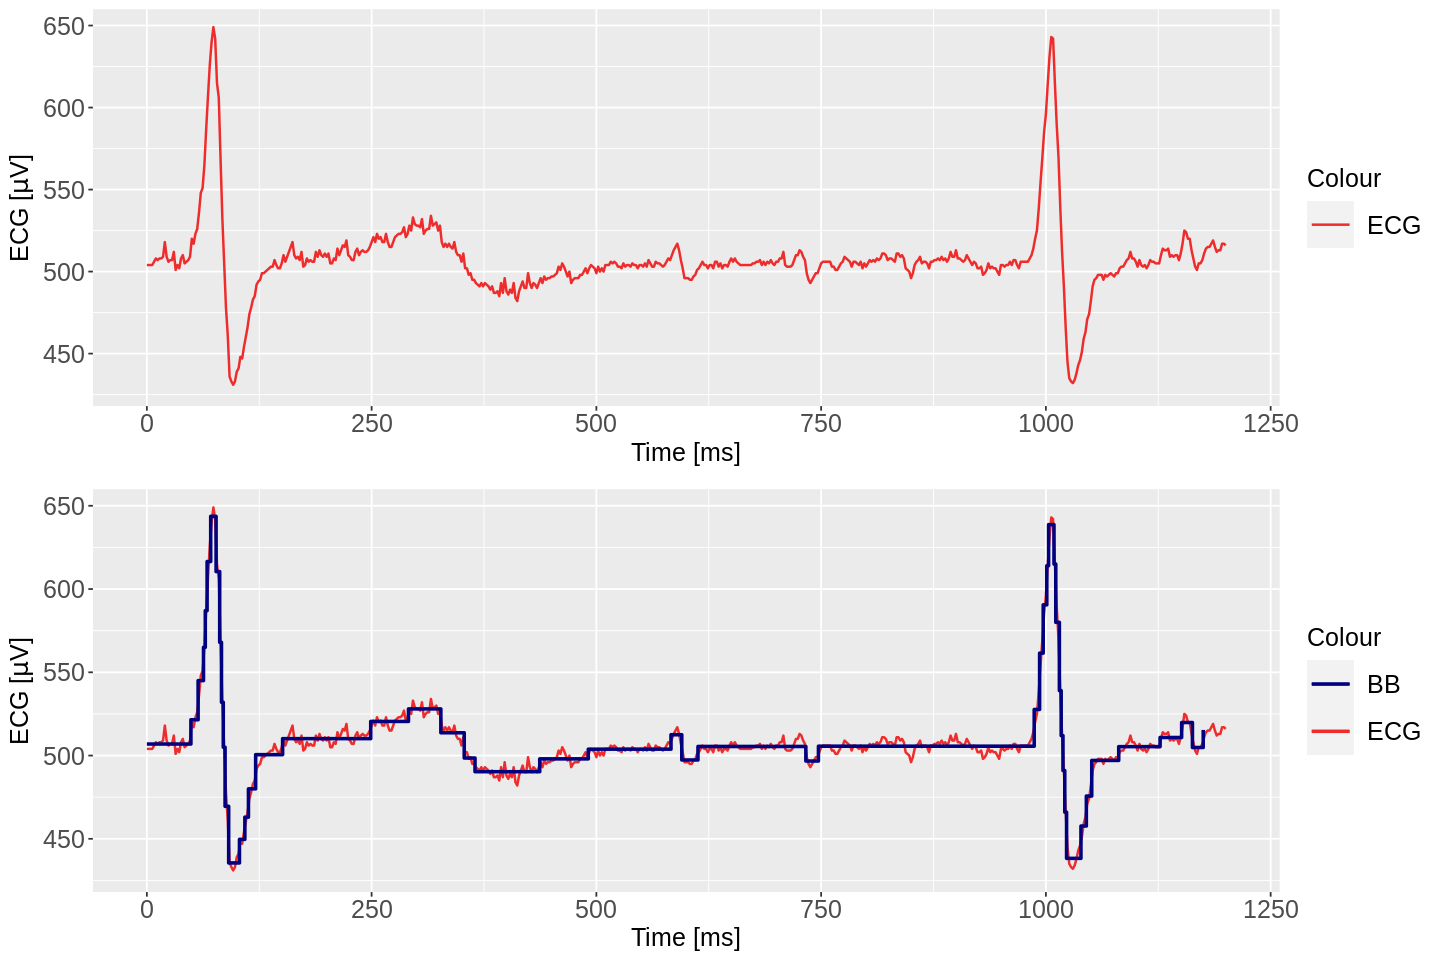

In [25]:
options(repr.plot.width = 12, repr.plot.height =8)
p.ecg = grid.arrange(grobs=list(p.ecg.mes, p.ecg.bb), nrow=2)